
## **Especialização em Inteligência Artificial – IFMG**

### Análise de Séries Temporais

### **Trabalho Final**

**Aluno:** Christhian Gonçalves

**Professor:** Carlos Severiano

A atividade consiste em aplicar alguma técnica de previsão de séries temporais (aprendida ou não na disciplina) a algum problema. Por exemplo, aplicar um modelo ARIMA a séries temporais de dados financeiros. Vocês têm total liberdade para escolher o problema a ser abordado!
Para isso, vocês devem primeiramente escolher uma base de dados a ser utilizada como estudo. Para facilitar na busca de dados para o trabalho, existem muitos sites que fornecem bases de dados, normalmente usadas em Aprendizado de Máquina. Eles costumam ter a vantagem de oferecer uma base já armazenada em algum formato de arquivo que seja mais fácil de ser  processado a partir de linguagens de programação mais direcionadas para esse fim, como Python, R, dentre outras. Alguns exemplos de sites que possuem bases prontas:
https://www.kaggle.com/
https://www.drivendata.org/
https://github.com/owid

Além disso, muitas séries temporais são armazenadas (e disponibilizadas em agências governamentais). Exemplos:
INPE:
https://www.gov.br/inpe/pt-br/acesso-a-informacao/dados-abertos
IPEA:
http://www.ipeadata.gov.br/Default.aspx

O trabalho poderá ser desenvolvido a partir de python notebooks, como vimos em sala. Nele, pode ser utilizada a parte textual para apresentar o problema e tudo o que foi desenvolvido em cada parte do trabalho. Se preferirem, a descrição pode ficar em um arquivo à parte de documentação, como um relatório em pdf ou arquivo readme de repositórios github.

O que será avaliado no trabalho:
- A descrição do problema abordado
- A descrição da base de dados usada (atributos, classes) ou o ambiente escolhido
- A correta aplicação da técnica
- A análise dos resultados (experimentos, divisão treinamento e teste, métricas de validação)
- A conclusão e indicação de trabalhos futuros

# Sobre o conjunto de dados
Este conjunto de dados contém informações oficiais de preços para os principais vegetais e frutas no Nepal de 2013 a 2021. O conjunto de dados inclui dados diários de preços para cada vegetal e fruta, bem como os preços máximo, mínimo e médio durante o período. Os preços são baseados em números oficiais e fornecem um recurso valioso para qualquer pessoa interessada em analisar os preços de commodities agrícolas no Nepal.

**Desenvolvendo estratégias de preços: ** Ao analisar as relações entre diferentes preços de vegetais e frutas, modelos de aprendizado de máquina podem ser usados ​​para desenvolver estratégias de preços para agricultores e comerciantes.

In [429]:
import yfinance as yf
import numpy as np
import pandas as pd
from io import StringIO
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
import time

In [430]:
data = pd.read_csv('kalimati_tarkari_dataset.csv')

# Verificar as primeiras linhas do dataset para entender sua estrutura
data.head(), data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197161 entries, 0 to 197160
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   SN         197161 non-null  int64  
 1   Commodity  197161 non-null  object 
 2   Date       197161 non-null  object 
 3   Unit       197161 non-null  object 
 4   Minimum    197161 non-null  float64
 5   Maximum    197161 non-null  float64
 6   Average    197161 non-null  float64
dtypes: float64(3), int64(1), object(3)
memory usage: 10.5+ MB


(   SN            Commodity        Date Unit  Minimum  Maximum  Average
 0   0   Tomato Big(Nepali)  2013-06-16   Kg     35.0     40.0     37.5
 1   1  Tomato Small(Local)  2013-06-16   Kg     26.0     32.0     29.0
 2   2           Potato Red  2013-06-16   Kg     20.0     21.0     20.5
 3   3         Potato White  2013-06-16   Kg     15.0     16.0     15.5
 4   4   Onion Dry (Indian)  2013-06-16   Kg     28.0     30.0     29.0,
 None)

In [431]:
# Filtrar os dados para uma commodity específica e preparar a série temporal
commodity_name = "Potato Red"
df = data[data["Commodity"] == commodity_name]

df = df[['Date', 'Average']]
# Converter a coluna "Date" para datetime e definir como índice
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

df = df.ffill()

# Exibir as primeiras entradas da série temporal
df.head(), df.describe()


(            Average
 Date               
 2013-06-16     20.5
 2013-06-17     20.5
 2013-06-18     19.5
 2013-06-19     20.5
 2013-06-20     20.5,
            Average
 count  2746.000000
 mean     35.419337
 std      15.210699
 min      15.000000
 25%      25.000000
 50%      32.000000
 75%      41.000000
 max     113.500000)

In [432]:
missing_values = df[df['Average'].isna()]
print(missing_values)

Empty DataFrame
Columns: [Average]
Index: []


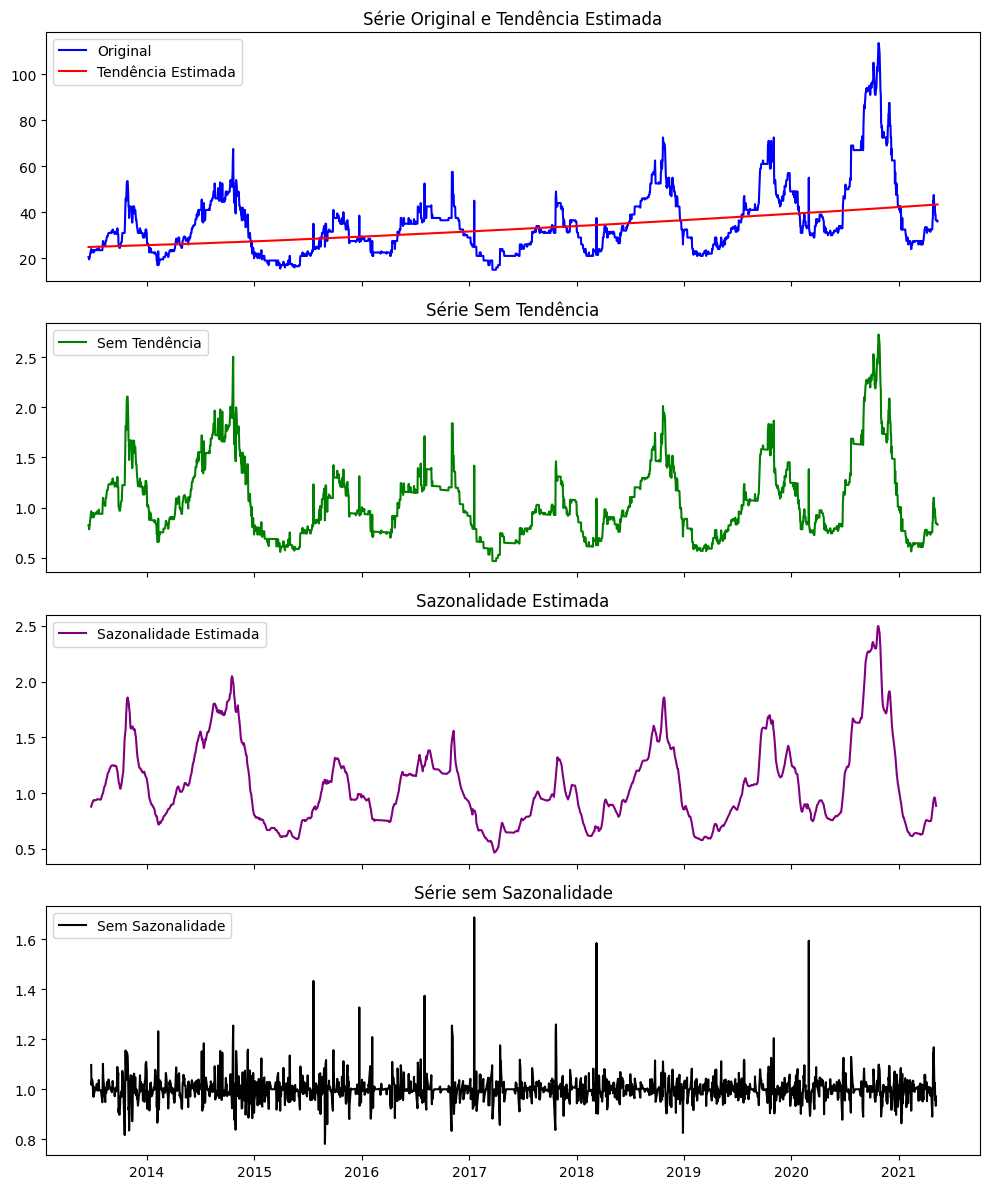

In [433]:
# Decomposição da série temporal
df['Log_Average'] = np.log(df['Average'])

# Ajustar modelo exponencial
time = np.arange(len(df))
model_trend = np.polyfit(time, df['Log_Average'], 1)
trend_exp = np.exp(model_trend[1] + model_trend[0] * time)

# 2: Eliminar a tendência estimada
df['Detrended'] = df['Average'] / trend_exp

# 3: Estimar sazonalidade através de médias móveis (janela de 12 meses)
df['Seasonal'] = df['Detrended'].rolling(window=12, center=True).mean()

# 4: Eliminar a sazonalidade
df['Deseasonalized'] = df['Detrended'] / df['Seasonal']


# Visualizar resultados do Roteiro 1
fig, axes = plt.subplots(4, 1, figsize=(10, 12), sharex=True)
axes[0].plot(df.index, df['Average'], label='Original', color='blue')
axes[0].plot(df.index, trend_exp, label='Tendência Estimada', color='red')
axes[0].legend(loc='upper left')
axes[0].set_title('Série Original e Tendência Estimada')

axes[1].plot(df.index, df['Detrended'], label='Sem Tendência', color='green')
axes[1].legend(loc='upper left')
axes[1].set_title('Série Sem Tendência')

axes[2].plot(df.index, df['Seasonal'], label='Sazonalidade Estimada', color='purple')
axes[2].legend(loc='upper left')
axes[2].set_title('Sazonalidade Estimada')

axes[3].plot(df.index, df['Deseasonalized'], label='Sem Sazonalidade', color='black')
axes[3].legend(loc='upper left')
axes[3].set_title('Série sem Sazonalidade')


plt.tight_layout()
plt.show()

Teste de Dickey-Fuller Aumentado:
ADF Statistic: -3.058058
p-value: 0.029817
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567

Teste de Dickey-Fuller Aumentado após diferenciação:
ADF Statistic: -63.042030
p-value: 0.000000
Critical Values:
	1%: -3.433
	5%: -2.863
	10%: -2.567


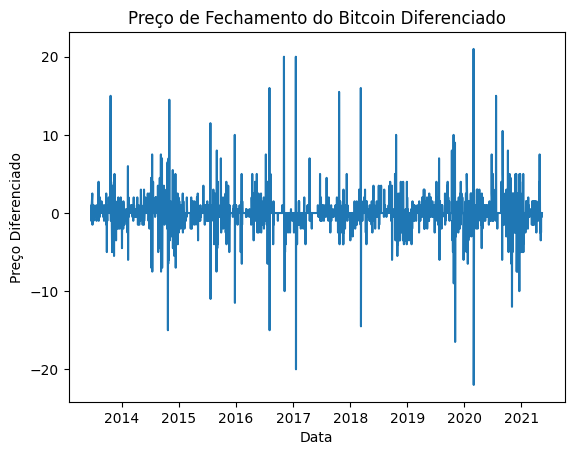

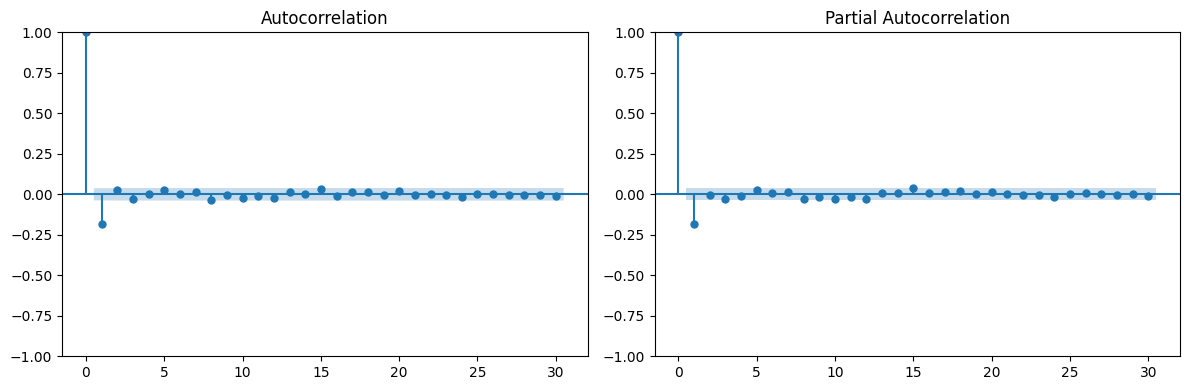

In [434]:
from statsmodels.tsa.stattools import adfuller

def adf_test(series):
    result = adfuller(series)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))

print("Teste de Dickey-Fuller Aumentado:")
adf_test(df['Average'])

# Diferenciação para tornar a série estacionária (se necessário):
data_diff = df['Average'].diff().dropna()

print("\nTeste de Dickey-Fuller Aumentado após diferenciação:")
adf_test(data_diff)

plt.plot(data_diff)
plt.title('Preço de Fechamento do Bitcoin Diferenciado')
plt.xlabel('Data')
plt.ylabel('Preço Diferenciado')
plt.show()

# Gráficos ACF e PACF para identificar a ordem do ARIMA após a diferenciação:
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data_diff, ax=axes[0], lags=30) #Ajuste o número de lags conforme necessário
plot_pacf(data_diff, ax=axes[1], lags=30) #Ajuste o número de lags conforme necessário
plt.tight_layout()
plt.show()

O valor ADF (-3.058) é maior que o valor crítico de 1% (-3.433). O p-valor (0.029817) é menor que 0.05, indicando que podemos rejeitar a hipótese nula de que a série contém uma raiz unitária (ou seja, não é estacionária). Apesar disso, a rejeição não é muito forte, sugerindo que a série original possui alguma tendência ou sazonalidade residual que pode afetar a análise. Embora o teste sugira que a série pode ser estacionária (p < 0.05), a estatística ADF não está muito abaixo dos valores críticos, o que indica que há forte indício de tendência ou sazonalidade. 

O valor ADF (-63.042) é significativamente menor que todos os valores críticos (1%, 5% e 10%).A série diferenciada é claramente estacionária, o que confirma que a diferenciação foi eficaz para remover tendências e sazonalidades.

In [435]:
import pandas as pd
import time
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Separar os dados em conjunto de treinamento e teste
cutoff = int(len(df) * 0.8)
train_data = df.iloc[:cutoff]
test_data = df.iloc[cutoff:]

# Ajuste do modelo ARIMA
start_time = time.time()
model = ARIMA(train_data['Average'], order=(2, 1, 2))
fitted_model = model.fit()
end_time = time.time()

if not isinstance(df.index, pd.DatetimeIndex):
    df.index = pd.to_datetime(df.index)

# Previsões
predictions = fitted_model.forecast(steps=len(test_data))
predictions = pd.Series(predictions, index=test_data.index)

# Verificando a presença de NaNs
print("NaNs em test_data:", test_data['Average'].isna().sum())
print("NaNs em predictions:", predictions.isna().sum())

# Tratamento de NaNs em test_data
if test_data['Average'].isna().sum() > 0:
    test_data['Average'].fillna(method='ffill', inplace=True)  # Forward fill

# Tratamento de NaNs em predictions
if predictions.isna().sum() > 0:
    #predictions.fillna(method='ffill', inplace=True)  # Forward fill
    # Ou, use o último valor conhecido
    predictions.fillna(test_data['Average'].iloc[-1], inplace=True)

# Recalcular as métricas
mae = mean_absolute_error(test_data['Average'], predictions)
rmse = np.sqrt(mean_squared_error(test_data['Average'], predictions))
mape = np.mean(np.abs(predictions - test_data['Average']) / np.abs(test_data['Average']))
r2 = r2_score(test_data['Average'], predictions)


# Exibir o resumo do modelo ajustado
print(fitted_model.summary())
print(predictions)
# Avaliação das previsões
from sklearn.metrics import mean_squared_error
mse = mean_squared_error(test_data['Average'], predictions)
print(f'Mean Squared Error: {mse}')
print(predictions)

c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


NaNs em test_data: 0
NaNs em predictions: 550
                               SARIMAX Results                                
Dep. Variable:                Average   No. Observations:                 2196
Model:                 ARIMA(2, 1, 2)   Log Likelihood               -4485.329
Date:                Wed, 18 Dec 2024   AIC                           8980.659
Time:                        01:35:49   BIC                           9009.129
Sample:                             0   HQIC                          8991.063
                               - 2196                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.2453      0.423      0.580      0.562      -0.584       1.074
ar.L2          0.1684      0.148      1.135      0.257      -0.122       0.459
ma.L1 

c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
c:\Users\chris\AppData\Local\Programs\Python\Python312\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


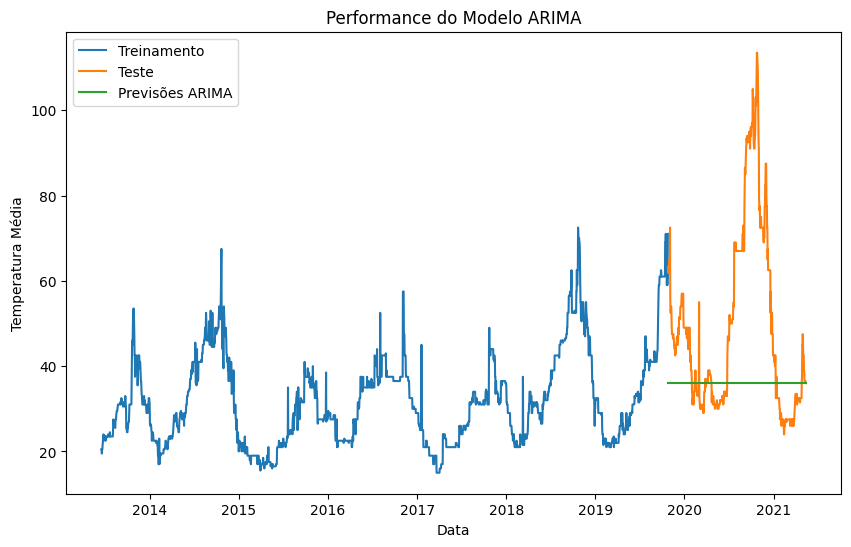

ARIMA {'MAE': 17.523636363636363, 'RMSE': np.float64(25.325588927909546), 'MAPE': np.float64(0.2863707018104513), 'R²': -0.39100862394217106} CPU {'p': 2, 'd': 1, 'q': 2} 0.7285819053649902


In [436]:
# Plotar a performance
plt.figure(figsize=(10, 6))
plt.plot(train_data['Average'], label='Treinamento')
plt.plot(test_data['Average'], label='Teste')
plt.plot(predictions, label='Previsões ARIMA')
plt.title('Performance do Modelo ARIMA')
plt.xlabel('Data')
plt.ylabel('Temperatura Média')
plt.legend()
plt.show()

# Adicionar registro de performance
print("ARIMA", {"MAE": mae, "RMSE": rmse, "MAPE": mape, "R²": r2},"CPU", {"p": 2, "d": 1, "q": 2}, end_time - start_time)

# Conclusão: 
Estacionariedade: A diferenciação conseguiu tornar a série temporal muito mais estacionária, removendo qualquer tendência não-estacionária que poderia estar presente na série original, mesmo que ela fosse fracamente estacionária. A diferenciação a tornou mais forte, o que é adequado para o modelo ARIMA.

Modelo ARIMA: O modelo ARIMA(2, 1, 2), os parâmetros do modelo são estatisticamente não significantes.

Qualidade do Ajuste: O modelo tem um desempenho ruim, com métricas de erro relativamente altas e um R² negativo. Isso sugere que o modelo não consegue capturar bem a variabilidade da série temporal.

O modelo ARIMA(2, 1, 2) atual não é adequado para a série temporal. Os testes de Dickey-Fuller confirmam que a diferenciação torna a série estacionária, mas o modelo ajustado não está conseguindo capturar os padrões. É necessário experimentar diferentes abordagens com modelos mais simples e métodos de pré-processamento. A análise dos resíduos, a validação cruzada, bem como a comparação com outros modelos são cruciais para melhorar a performance da previsão.